In [2]:
import numpy as np
import scipy.integrate as integrate
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import bm3d

# Question 1


### Defining integrands

In [3]:
def Diagonal_integrand(x,i):
    binom_coeff = 120/(np.math.factorial(i-1)*np.math.factorial(5-i))
    g = np.power(x,2)*0.5*binom_coeff*np.power((1+x)/2 , i-1) * np.power((1-x)/2 , 5-i)   
    return g

In [4]:
def Off_diagonal_integrand(x,y,i,j):
    binom_coeff = 120/(np.math.factorial(i-1)*np.math.factorial(j-i-1)*np.math.factorial(5-j))
    g = x*y*0.25*binom_coeff*np.power((1+x)/2 , i-1) * np.power((y-x)/2 , j-i-1) * np.power((1-y)/2 , 5-j)   
    return g

### Computing H Matrix

In [5]:
def compute_H_matrix():
    H = np.zeros((5,5))
    for i in range(5):
        for j in range(i,5):
            if(i==j):
                temp = integrate.quad(Diagonal_integrand,-1,1,args=(i+1,))
                H[i][j] = temp[0]
            else:
                temp = integrate.dblquad(Off_diagonal_integrand,-1,1,-1,lambda x:x,args=(i+1,j+1))
                H[i][j] = temp[0]
                H[j][i] = H[i][j]
    return H

### Computing alpha

In [8]:
H = compute_H_matrix()
e = np.ones(5)
alpha = np.linalg.inv(H)@e/(e@np.linalg.inv(H)@e.T)
print(np.round(alpha,2))

[ 0.5  0.  -0.  -0.   0.5]


# Question 2

In [9]:
image = io.imread('lighthouse2.bmp')
original_image = (rgb2gray(image)*255).astype(int)

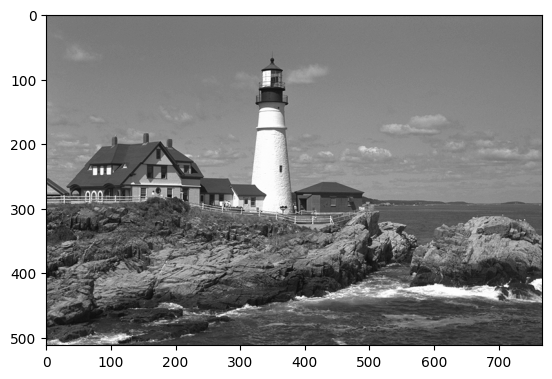

In [10]:
plt.imshow(original_image,cmap = 'gray')

### Adding Gaussian Noise to Image

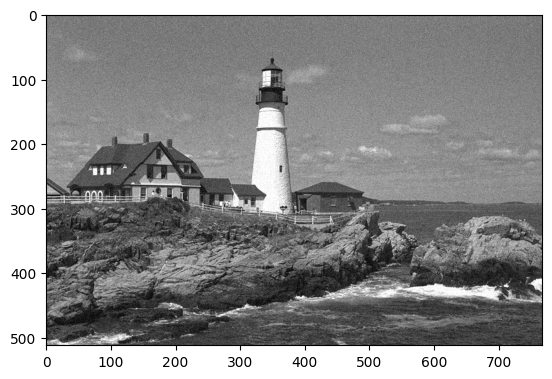

In [11]:
h = original_image.shape[0]
w = original_image.shape[1]

# creating white gaussian noise
sigma = 10
z = np.random.normal(0,sigma , size=[h, w]) # var_z = 100, thus sigma_z = 10

# noisy image y
y = np.clip(original_image + z, 0, 255)

plt.imshow(y, cmap='gray')

In [12]:
first_stage_output = bm3d.bm3d(y,sigma_psd = 10,stage_arg = bm3d.BM3DStages.HARD_THRESHOLDING)
second_stage_output = bm3d.bm3d(y,sigma_psd = 10,stage_arg = bm3d.BM3DStages.ALL_STAGES)

In [16]:
first_stage_MSE = np.mean((original_image-first_stage_output)**2)
second_stage_MSE = np.mean((original_image-second_stage_output)**2)
print("MSE for first stage output: ",first_stage_MSE)
print("MSE for second stage output: ",second_stage_MSE)

MSE for first stage output:  32.9445599606207
MSE for second stage output:  27.991241997061405


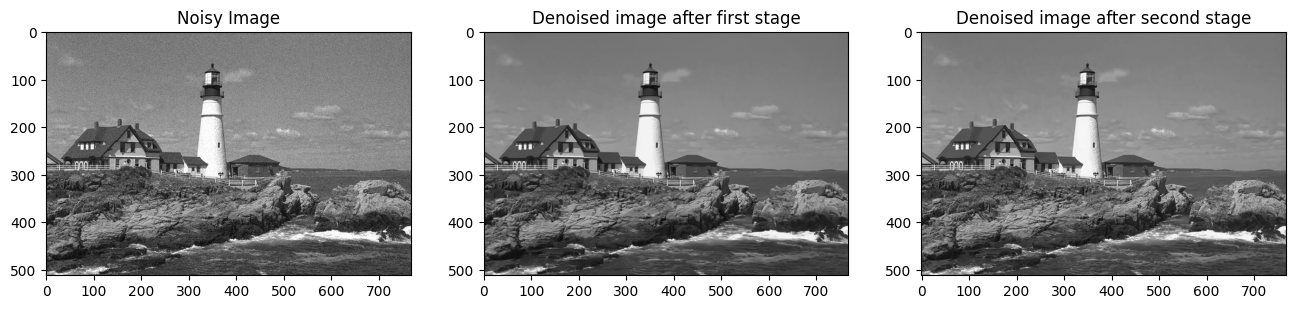

In [22]:
fig, axis = plt.subplots(1, 3, figsize = (16, 8))
axis[0].imshow(y, cmap = 'gray')
axis[0].set_title('Noisy Image')
axis[1].imshow(first_stage_output, cmap = 'gray')
axis[1].set_title('Denoised image after first stage')
axis[2].imshow(second_stage_output, cmap = 'gray')
axis[2].set_title('Denoised image after second stage')
plt.show()

# Question 2

In [ ]:
MSE = []
sigma_psd = []
for i in range(1,21):
    output = bm3d.bm3d(y,sigma_psd = i,stage_arg = bm3d.BM3DStages.ALL_STAGES)
    output_mse = np.mean((original_image-output)**2)
    MSE.append(output_mse)
    sigma_psd.append(i)


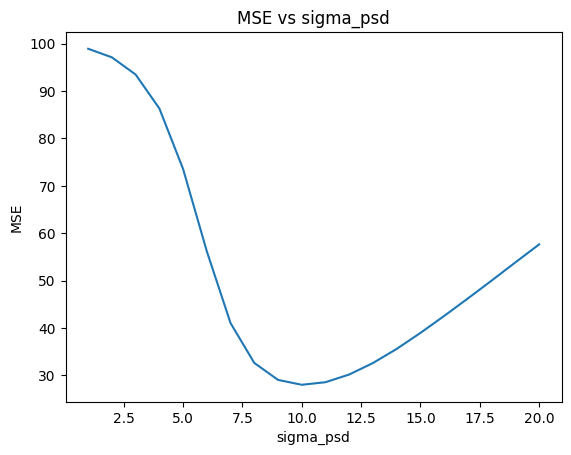

In [23]:
plt.plot(sigma_psd,MSE)
plt.xlabel('sigma_psd')
plt.ylabel('MSE')
plt.title('MSE vs sigma_psd')
plt.show()

# Question 3

In [19]:
MSE2 = []
sigma_psd2 = []

stage_1_output = bm3d.bm3d(y,sigma_psd = 10,stage_arg = bm3d.BM3DStages.HARD_THRESHOLDING)
t = 0
for i in range(0,10):
    stage_1_output2 = bm3d.bm3d(stage_1_output,sigma_psd = t,stage_arg = bm3d.BM3DStages.HARD_THRESHOLDING)
    output_mse2 = np.mean((original_image-stage_1_output2)**2)
    MSE2.append(output_mse2)
    sigma_psd2.append(t)
    t += 0.1 

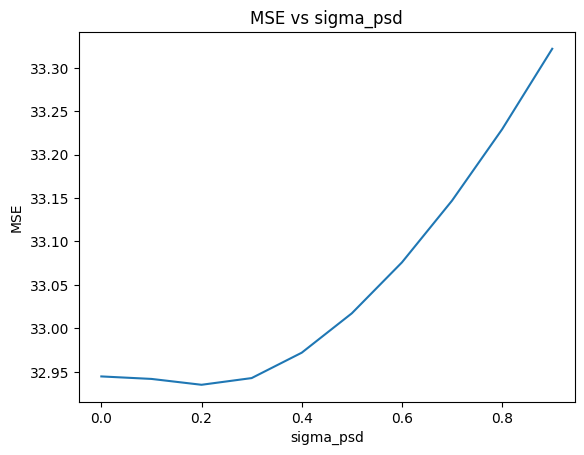

In [24]:
plt.plot(sigma_psd2,MSE2)
plt.xlabel('sigma_psd')
plt.ylabel('MSE')
plt.title('MSE vs sigma_psd')
plt.show()

In [26]:
np.argmin(MSE2)

2

MSE loss with Wiener filter:  27.991241997061405
MSE loss with twice Hardthresholding Estimate:  32.93494881042101


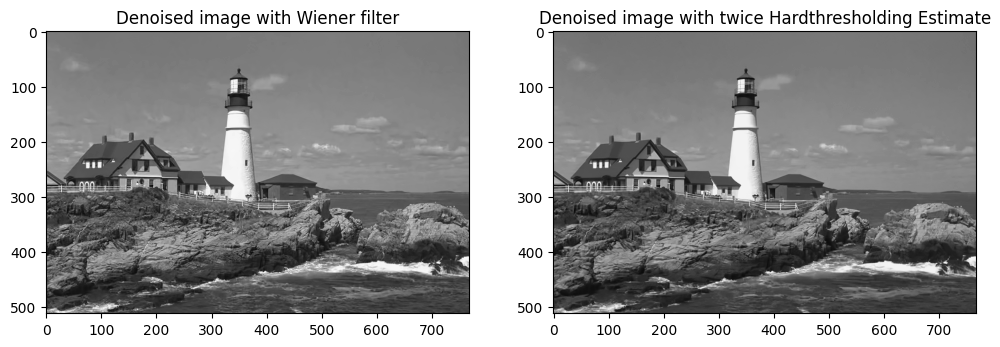

In [29]:
hard_threshold_2 = bm3d.bm3d(stage_1_output,sigma_psd = sigma_psd2[np.argmin(MSE2)],stage_arg = bm3d.BM3DStages.HARD_THRESHOLDING)
print('MSE loss with Wiener filter: ', second_stage_MSE)
print('MSE loss with twice Hardthresholding Estimate: ', min(MSE2))
fig, axis = plt.subplots(1, 2, figsize = (12, 8))
# axis[0].imshow(noisy_image, cmap = 'gray')
axis[1].imshow(hard_threshold_2, cmap = 'gray')
axis[1].set_title('Denoised image with twice Hardthresholding Estimate')
axis[0].imshow(second_stage_output, cmap = 'gray')
axis[0].set_title('Denoised image with Wiener filter')
plt.show()